In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/project_ae')

In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install torchinfo

# Convolutional Auto-encoder - Camus Dataset


This notebook shows how to train, test and evaluate a Convolutional Auto-encoder to generate an output label exactly as input, so the segmented shape. The dataset is available on [CAMUS dataset](https://humanheart-project.creatis.insa-lyon.fr/database/#collection/6373703d73e9f0047faa1bc8).


# I. Install dependencies <a class="anchor" id="install"></a>


In [ ]:
%%capture project_path_setup

import sys

if "../" in sys.path:
    print(sys.path)
else:
    sys.path.append("../")
    print(sys.path)

In [ ]:
%%capture packages_install

# Make sure the repo's package and its dependencies are installed
%pip install -e ../.

# II. Dataset <a class="anchor" id="dataset"></a>

Once the environment is successfully setup, download the CAMUS dataset by executing the following cell. The dataset will be downloaded to the `data/` folder.

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm

# Make sure the data is downloaded and extracted where it should be
if not Path("../data/camus_64").is_dir():
    import zipfile
    from io import BytesIO
    from urllib.request import urlopen

    zipurl = "https://www.creatis.insa-lyon.fr/~bernard/camus/camus_64.zip"
    with urlopen(zipurl) as zipresp:
        with zipfile.ZipFile(BytesIO(zipresp.read())) as zfile:
            for member in tqdm(
                zfile.infolist(), desc="Downloading and extracting data", position=0, leave=True
            ):
                try:
                  zfile.extract(member, "../data/")
                except zipfile.error as e:
                    pass

Data splitting into training, validation and testing sets (80% of the data for training, 10% for validation and 10% for testing). The split is done by patient ID, so that the same patient will not appear in different sets.

In [ ]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from src.utils.file_and_folder_operations import subdirs

# Specify the data directory
data_dir = Path("../data/camus_64").resolve()

# List all the patients id
keys = subdirs(data_dir, prefix="patient", join=False)

# Split the patients into 80/10/10 train/val/test sets
train_keys, val_and_test_keys = train_test_split(keys, train_size=0.6, random_state=12345)
val_keys, test_keys = train_test_split(val_and_test_keys, test_size=0.5, random_state=12345)

train_keys = sorted(train_keys)
val_keys = sorted(val_keys)
test_keys = sorted(test_keys)

# Create train, val and test datalist
viws_instants = ["2CH_ED", "2CH_ES", "4CH_ED", "4CH_ES"]
train_datalist = [
    {
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in train_keys
    for view in viws_instants
]

val_datalist = [
    {
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in val_keys
    for view in viws_instants
]

test_datalist = [
    {
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in test_keys
    for view in viws_instants
]

Once the data is split, we will create a `Dataset` object for each set. This object will be used to load the data during training and testing.

In [ ]:
import numpy as np
from monai.data import CacheDataset, meta_tensor
from monai.transforms import Compose, EnsureChannelFirstd, LoadImaged, RandFlipd, RandRotated, RandZoomd, Lambda, MapTransform, ToTensor

class ConvertToFourChannels(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        image = data[self.keys[0]]
        four_channel_image = np.zeros((4, 64, 64), dtype=np.float32)
        for i in range(4):
            four_channel_image[i, image[0] == i] = 1.0
            four_channel_image[i, image[0] != i] = 0.0
        data[self.keys[0]] = four_channel_image
        return data

# Transforms to load data
load_transforms = [
    LoadImaged(keys=["label"], image_only=True),  # Load label
    EnsureChannelFirstd(keys=["label"]),  # Make sure the first dimension is the channel dimension
    ConvertToFourChannels(keys=["label"]),
    ToTensor(),
]

range_x = [-15.0 / 180 * np.pi, 15.0 / 180 * np.pi]
data_augmentation_transforms = [
    RandRotated(
        keys="label",
        range_x=range_x,
        range_y=0,
        range_z=0,
        mode="nearest",
        padding_mode="zeros",
        prob=0.2,
    ),
    RandFlipd(keys="label", spatial_axis=[0], prob=0.5),
]

# Define transforms for training, validation and testing
train_transforms = Compose(load_transforms + data_augmentation_transforms)
val_transforms = Compose(load_transforms)
test_transforms = Compose(load_transforms)

# Use CacheDataset to accelerate training and validation
train_ds = CacheDataset(data=train_datalist, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms, cache_rate=1.0)
test_ds = CacheDataset(data=test_datalist, transform=test_transforms, cache_rate=1.0)

train_sample = train_ds[0]
val_sample = val_ds[0]
test_sample = train_ds[0]
print("\n")
print(type(train_sample["label"]))
print(type(val_sample["label"]))
print(type(test_sample["label"]))

Loading dataset: 100%|██████████| 400/400 [00:01<00:00, 298.81it/s]




<class 'monai.data.meta_tensor.MetaTensor'>
<class 'monai.data.meta_tensor.MetaTensor'>
<class 'monai.data.meta_tensor.MetaTensor'>


In [ ]:
import torch

def ConvertToOneChannel(img):
  argmax_img = torch.argmax(img,dim=0)
  one_channel_img = argmax_img.unsqueeze(0)
  result = one_channel_img.detach().cpu().numpy()[0].transpose(1, 0)
  return result

train_idx:  251
val_idx:  241
test_idx:  311


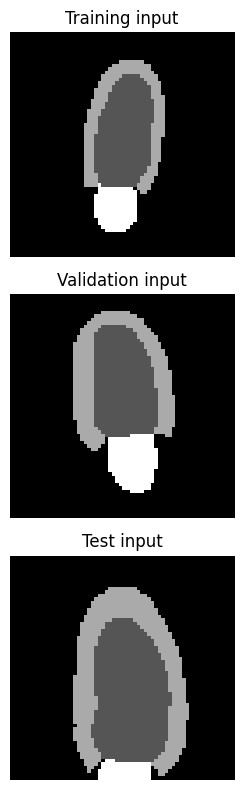

In [ ]:
from matplotlib import pyplot as plt
from src.utils.visualizations import imagesc

# Get a random index to display the example annotation from each dataset
train_idx = np.random.randint(len(train_ds))
val_idx = np.random.randint(len(val_ds))
test_idx = np.random.randint(len(test_ds))

# Print the selected indices
print("train_idx: ", train_idx+1)
print("val_idx: ", val_idx+1)
print("test_idx: ", test_idx+1)

# Visualize a random example from each dataset
figure = plt.figure(figsize=(8, 8))
train_sample = train_ds[train_idx]
label = ConvertToOneChannel(train_sample["label"])
ax = figure.add_subplot(3, 1, 1)
imagesc(ax, label, title="Training input", show_colorbar=False)

val_sample = val_ds[val_idx]
label = ConvertToOneChannel(val_sample["label"])
ax = figure.add_subplot(3, 1, 2)
imagesc(ax, label, title="Validation input", show_colorbar=False)

test_sample = test_ds[test_idx]
label = ConvertToOneChannel(test_sample["label"])
ax = figure.add_subplot(3, 1, 3)
imagesc(ax, label, title="Test input", show_colorbar=False)
figure.tight_layout()
plt.show()

In [ ]:
#np.unique(label)
img = test_ds[0]
np.unique(img)

array([{'label': metatensor([[[1., 1., 1.,  ..., 1., 1., 1.],
                [1., 1., 1.,  ..., 1., 1., 1.],
                [1., 1., 1.,  ..., 1., 1., 1.],
                ...,
                [1., 1., 1.,  ..., 1., 1., 1.],
                [1., 1., 1.,  ..., 1., 1., 1.],
                [1., 1., 1.,  ..., 1., 1., 1.]],

               [[0., 0., 0.,  ..., 0., 0., 0.],
                [0., 0., 0.,  ..., 0., 0., 0.],
                [0., 0., 0.,  ..., 0., 0., 0.],
                ...,
                [0., 0., 0.,  ..., 0., 0., 0.],
                [0., 0., 0.,  ..., 0., 0., 0.],
                [0., 0., 0.,  ..., 0., 0., 0.]],

               [[0., 0., 0.,  ..., 0., 0., 0.],
                [0., 0., 0.,  ..., 0., 0., 0.],
                [0., 0., 0.,  ..., 0., 0., 0.],
                ...,
                [0., 0., 0.,  ..., 0., 0., 0.],
                [0., 0., 0.,  ..., 0., 0., 0.],
                [0., 0., 0.,  ..., 0., 0., 0.]],

               [[0., 0., 0.,  ..., 0., 0., 0.],
     

# III. Train <a class="anchor" id="train"></a>


### Definition of Convolutional Auto-encoder architecture

Create a convolutional auto-encoder.

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
            nn.Dropout2d(p=0.2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to modify the number of channels
        if bilinear:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                DoubleConv(in_channels, out_channels),
                nn.Dropout2d(p=0.2)
            )
        else:
            self.up = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=0.2)
            )

    def forward(self, x):
        return self.up(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class CompressConv(nn.Module):
    def __init__(self, in_channels, compress_channel):
        super(CompressConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, compress_channel, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DeCompressConv(nn.Module):
    def __init__(self, compress_channel, out_channels):
        super(DeCompressConv, self).__init__()
        self.conv = nn.Conv2d(compress_channel, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class AE_Conv(nn.Module):
    def __init__(self, in_channels, out_channels, init_channel, compress_channel, bilinear=True):
        super(AE_Conv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.init_channel = init_channel
        self.compress_channel = compress_channel
        self.bilinear = bilinear

        self.inc = DoubleConv(in_channels, init_channel)
        self.down1 = Down(init_channel, init_channel*2)
        self.down2 = Down(init_channel*2, init_channel*4)
        self.down3 = Down(init_channel*4, init_channel*8)
        self.down4 = Down(init_channel*8, init_channel*16)
        self.compress = CompressConv(init_channel*16, compress_channel)
        self.decompress = DeCompressConv(compress_channel, init_channel*16)
        self.up4 = Up(init_channel*16, init_channel*8, bilinear)
        self.up3 = Up(init_channel*8, init_channel*4, bilinear)
        self.up2 = Up(init_channel*4, init_channel*2, bilinear)
        self.up1 = Up(init_channel*2, init_channel, bilinear)
        self.outc = OutConv(init_channel, out_channels)

        self._initialize_weights()

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)
        x = self.compress(x)
        x = self.decompress(x)
        x = self.up4(x)
        x = self.up3(x)
        x = self.up2(x)
        x = self.up1(x)
        x = self.outc(x)
        x = torch.sigmoid(x)
        return x

    def _initialize_weights(self):
       for m in self.modules():
           if isinstance(m, nn.Conv2d):
               nn.init.kaiming_normal_(m.weight)
               if m.bias is not None:
                   nn.init.zeros_(m.bias)
           elif isinstance(m, nn.BatchNorm2d):
               nn.init.constant_(m.weight, 1)
               nn.init.constant_(m.bias, 0)

In [ ]:
from torchinfo import summary
import torch

input_channel = 4  # This is the number of input channels in the image
input_shape = (input_channel, 64, 64)  # This is the shape of the input image to the network
output_channel = 4  # This is the number of output channel
output_shape = (output_channel, 64, 64)  # This is the shape of the output image
init_channel = 64  # This is the output channel's number of input convolution
compress_channel = 1  # This is the channel's number of compress convolution at the end of bottleneck

ae_conv = AE_Conv(input_channel, output_channel, init_channel, compress_channel)

# Print the summary of the network
summary_kwargs = dict(col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=3, verbose=0)
summary(ae_conv, (1, *input_shape), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                        Input Shape               Output Shape              Kernel Shape              Param #
AE_Conv                                       [1, 4, 64, 64]            [1, 4, 64, 64]            --                        --
├─DoubleConv: 1-1                             [1, 4, 64, 64]            [1, 64, 64, 64]           --                        --
│    └─Sequential: 2-1                        [1, 4, 64, 64]            [1, 64, 64, 64]           --                        --
│    │    └─Conv2d: 3-1                       [1, 4, 64, 64]            [1, 64, 64, 64]           [3, 3]                    2,368
│    │    └─BatchNorm2d: 3-2                  [1, 64, 64, 64]           [1, 64, 64, 64]           --                        128
│    │    └─ReLU: 3-3                         [1, 64, 64, 64]           [1, 64, 64, 64]           --                        --
│    │    └─Conv2d: 3-4                       [1, 64, 64, 64]           [1, 64, 64, 64]           [3, 

In [ ]:
import numpy as np
import torch

# Test the pixel value range of auto-encoder input and output
random_image = np.random.rand(4, 64, 64)
tensor_image = torch.FloatTensor(random_image)
tensor_image = tensor_image.unsqueeze(0)
with torch.no_grad():
    ae_output = ae_conv(tensor_image)

print("Random Image:")
print(random_image)

print("\nAE Output:")
print(ae_output.squeeze().numpy())

Random Image:
[[[0.40634392 0.44655707 0.7200133  ... 0.92205171 0.49655599 0.15032515]
  [0.03731024 0.43588918 0.77017014 ... 0.6751989  0.06780271 0.28338791]
  [0.92225804 0.03097123 0.05864253 ... 0.9027525  0.27272563 0.04633574]
  ...
  [0.63339535 0.44517873 0.36368804 ... 0.00617724 0.73831086 0.80250352]
  [0.16873122 0.27738017 0.44708017 ... 0.31488675 0.35750604 0.95736208]
  [0.95462972 0.23214933 0.48949234 ... 0.03490778 0.04487214 0.42922015]]

 [[0.49377617 0.55241873 0.08945515 ... 0.6430419  0.72679093 0.4221668 ]
  [0.32858111 0.95313907 0.6088243  ... 0.92034598 0.36956659 0.49653601]
  [0.85053202 0.05071477 0.38377395 ... 0.97760118 0.98600936 0.91648323]
  ...
  [0.03591399 0.57059547 0.64122479 ... 0.48219933 0.76939828 0.63125753]
  [0.0562683  0.92269163 0.69599004 ... 0.60659461 0.00551098 0.68495629]
  [0.77437489 0.49949411 0.26098624 ... 0.97997935 0.51235998 0.99285396]]

 [[0.71416009 0.36506329 0.52934635 ... 0.81333203 0.77461145 0.64525605]
  [0.549

### Definition of training function

In [ ]:
import os
import time
from typing import Union

import torch.nn.functional as F
from monai.data import DataLoader
from torch import nn
from torch.utils.data import Dataset
from tqdm.auto import tqdm

from skimage.metrics import structural_similarity as ssim

def train_process(
    train_ds: Dataset,
    val_ds: Dataset,
    num_workers: int,
    model: nn.Module,
    loss_function: nn.Module,
    loss_weights: torch.Tensor,
    optimizer: torch.optim.Optimizer,
    sheduler: torch.optim.lr_scheduler._LRScheduler,
    batch_size: int = 4,
    max_epochs: int = 200,
    log_dir: Union[Path, str] = Path("/content/drive/MyDrive/project_ae/logs/ae/ae_second_step"),
    val_interval=1,
) -> tuple[float, list[float], list[float], list[int], list[float]]:
    """Trains a neural network model for segmentation on the provided datasets using the specified parameters.

    Args:
        train_ds: Training dataset.
        val_ds: Validation dataset.
        num_workers: Number of workers to use for data loading.
        model: Neural network model.
        loss_function: Loss function.
        optimizer: Optimizer.
        num_classes: Number of classes to segment.
        batch_size: Number of batch size. Defaults to 2.
        max_epochs: Maximum training epochs. Defaults to 30.
        log_dir: Path to the logging directory. Defaults to Path("../logs/camus_segmentation").
        val_interval: Epoch interval to perform evaluation steps. Defaults to 1.

    Returns:
        - Total time taken for training.
        - List containing training loss values for each epoch.
        - List containing validation loss values for each evaluation epoch.
        - List containing epochs where validation is performed.
        - List containing metric values for each evaluation epoch.
    """
    # Create train and validation dataloaders
    train_dataloader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    val_dataloader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )

    # Determine the device to run the model on
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU detected, training on: {device}!\n")
    else:
        device = torch.device("cpu")
        print("GPU not detected, training on CPU!\n")

    # Move the model to the device
    model = model.to(device)
    loss_weights  =loss_weights.to(device)
    # Convert log directory to Path object if needed
    if not isinstance(log_dir, Path):
        log_dir = Path(log_dir)
    # Create the log directory if it does not exist
    log_dir.mkdir(parents=True, exist_ok=True)

    # Define some variables to keep track of the best metric values, epoch time and losses
    best_metric = -1
    best_metric_epoch = -1
    epoch_train_loss_values = []
    epoch_val_loss_values = []
    metric_values = []
    epoch_val = []
    total_start = time.time()

    accuracy_list = []
    ssim_list = []

    fit_pbar = tqdm(range(max_epochs), desc="Training", unit="epoch", position=0, leave=True)
    pbar_metrics = {"train/loss": None, "val/loss": None, "val/accuracy": None, "val/ssim": None}

    for epoch in fit_pbar:
        model.train()
        epoch_loss = 0
        epoch_val_loss = 0
        epoch_ssim = 0
        epoch_acc = 0
        step = 0
        for batch_data in train_dataloader:
            step += 1
            inputs = batch_data["label"].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            weighted_inputs = inputs * loss_weights
            weighted_outputs = outputs * loss_weights
            loss = loss_function(weighted_outputs, weighted_inputs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar_metrics["loss"] = loss.item()
            pbar_metrics["train_batch"] = f"{step}/{len(train_dataloader)}"
            fit_pbar.set_postfix(pbar_metrics)

        epoch_loss /= step
        epoch_train_loss_values.append(epoch_loss)
        pbar_metrics["train/loss"] = epoch_loss
        pbar_metrics.pop("loss")
        pbar_metrics.pop("train_batch")
        fit_pbar.set_postfix(pbar_metrics)
        if (epoch + 1) % val_interval == 0:
            step = 0
            acc_per_epoch = 0
            ssim_per_epoch = 0
            model.eval()
            with torch.no_grad():
                for val_data in val_dataloader:
                    step += 1
                    val_inputs = val_data["label"].to(device)

                    val_outputs = model(val_inputs)
                    weighted_val_outputs = val_outputs * loss_weights
                    weighted_val_inputs = val_inputs * loss_weights
                    val_loss = loss_function(weighted_val_outputs, weighted_val_inputs)
                    epoch_val_loss += val_loss.item()
                    pbar_metrics["loss"] = val_loss.item()
                    pbar_metrics["val_batch"] = f"{step}/{len(val_dataloader)}"
                    fit_pbar.set_postfix(pbar_metrics)

                    if val_inputs.size() != val_outputs.size():
                      raise ValueError("Error!")

                    one_channel_val_outputs = torch.argmax(val_outputs, dim=1, keepdim=True)
                    one_channel_val_inputs = torch.argmax(val_inputs, dim=1, keepdim=True)

                    # accuracy calculation for 1 batch without counting background
                    mask = (one_channel_val_inputs > 0).float()
                    masked_correct_pixel = torch.sum(torch.eq(one_channel_val_inputs, one_channel_val_outputs) * mask).item()
                    masked_total_pixel = torch.sum(mask).item()

                    acc = (masked_correct_pixel / masked_total_pixel) * 100
                    acc_per_epoch += acc

                    # correct_pixel = torch.sum(torch.eq(one_channel_val_inputs, one_channel_val_outputs)).item()
                    # total_pixel = one_channel_val_inputs.numel()
                    # acc = (correct_pixel / total_pixel) * 100
                    # acc_per_epoch += acc

                    # ssim calculation for 1 batch
                    ssim_per_sample = 0
                    out_np = one_channel_val_outputs.cpu().detach().numpy()
                    in_np = one_channel_val_inputs.cpu().detach().numpy()
                    for i in range(out_np.shape[0]):
                        # if np.all(out_np[i, 0] == in_np[i, 0]):
                        #     print("yes")
                        # else:
                        #     print("no")
                        ssim_per_sample += ssim(out_np[i,0], in_np[i,0])
                        print(ssim_per_sample)
                    ssim_per_epoch += ssim_per_sample / out_np.shape[0]


                epoch_val_loss /= step
                epoch_val_loss_values.append(epoch_val_loss)
                epoch_val.append(epoch + 1)
                pbar_metrics.pop("loss")
                pbar_metrics.pop("val_batch")
                pbar_metrics["val/loss"] = float(epoch_val_loss)

                epoch_acc = acc_per_epoch / step
                pbar_metrics["val/accuracy"] = epoch_acc
                fit_pbar.set_postfix(pbar_metrics)
                accuracy_list.append(epoch_acc)

                epoch_ssim = ssim_per_epoch / step
                pbar_metrics["val/ssim"] = epoch_ssim
                fit_pbar.set_postfix(pbar_metrics)
                ssim_list.append(epoch_ssim)

                val_metric = epoch_acc
                metric_values.append(val_metric)


                if val_metric > best_metric:
                    best_metric = val_metric
                    best_metric_epoch = epoch + 1
                    # Save best metric model checkpoint
                    torch.save(
                        {
                            "max_epochs": max_epochs,
                            "current_epoch": epoch + 1,
                            "best_metric_epoch": best_metric_epoch,
                            "train_loss": epoch_train_loss_values,
                            "val_loss": epoch_val_loss_values,
                            "epoch_val": epoch_val,
                            "metric_values": metric_values,
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                        },
                        str(log_dir / "best_metric_model_checkpoint_16.pth"),
                    )

                    # Save the best whole model
                    torch.save(model, str(log_dir / "best_metric_model_16.pth"))

        scheduler.step()

        # Save last model checkpoint
        # torch.save(
        #     {
        #         "max_epochs": max_epochs,
        #         "current_epoch": epoch + 1,
        #         "best_metric_epoch": best_metric_epoch,
        #         "train_loss": epoch_train_loss_values,
        #         "val_loss": epoch_val_loss_values,
        #         "epoch_val": epoch_val,
        #         "metric_values": metric_values,
        #         "model_state_dict": model.state_dict(),
        #         "optimizer_state_dict": optimizer.state_dict(),
        #     },
        #     str(log_dir / "last_model_checkpoint.pth"),
        # )

        # Save the whole model
        # torch.save(model, str(log_dir / "last_model.pth"))

    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {(time.time() - total_start):.4f}"
    )
    return (
        time.time() - total_start,
        epoch_train_loss_values,
        epoch_val_loss_values,
        epoch_val,
        metric_values,
        accuracy_list,
        ssim_list
    )

### Definition of optimizer and loss function
We will define the parameters and hyperparameters for training, such as the number of epochs, the learning rate, the batch size, etc. We will also use the Adam optimizer. The loss function is the MSE loss with weighting.

In [ ]:
from functools import partial
import torch
from torch.nn import MSELoss

batch_size = 4  # Number of batch size
max_epochs = 50  # Number of epochs to train the model
num_workers = os.cpu_count() - 1  # Number of workers to use for data loading

sample = train_ds[0]
sample_size = sample["label"].shape
channels = sample_size[0]
height = sample_size[1]
width = sample_size[2]
loss_weights = torch.ones((batch_size, channels, height, width))
loss_weights[:, 1:] *= 3

loss_function = MSELoss()

optimizer = torch.optim.Adam(ae_conv.parameters(),lr=0.01,betas=(0.9,0.999),eps=1e-04,weight_decay=0.0005,amsgrad=False)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.01 if epoch < 5 else (0.005 if 5 <= epoch < 15 else 0.001))


### Definition of training hyperparameters
In this section, we will train the model.

In [ ]:
# Train the model
(
    total_time,
    epoch_train_loss_values,
    epoch_val_loss_values,
    epoch_val,
    metric_values,
    accuracy_list,
    ssim_list
) = train_process(
    train_ds=train_ds,
    val_ds=val_ds,
    num_workers=num_workers,
    model=ae_conv,
    loss_function=loss_function,
    loss_weights=loss_weights,
    optimizer=optimizer,
    sheduler=scheduler,
    batch_size=batch_size,
    max_epochs=max_epochs,
    log_dir="/content/drive/MyDrive/project_ae/logs/ae/ae_second_step",
)

GPU detected, training on: cuda!



Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0
no
4.0
no
1.0
no
2.0
no
3.0

KeyboardInterrupt: ignored

# IV. Visualize learning curves and predictions <a class="anchor" id="visualize"></a>

### Plot training losses, validation losses and validation SSIM over epochs

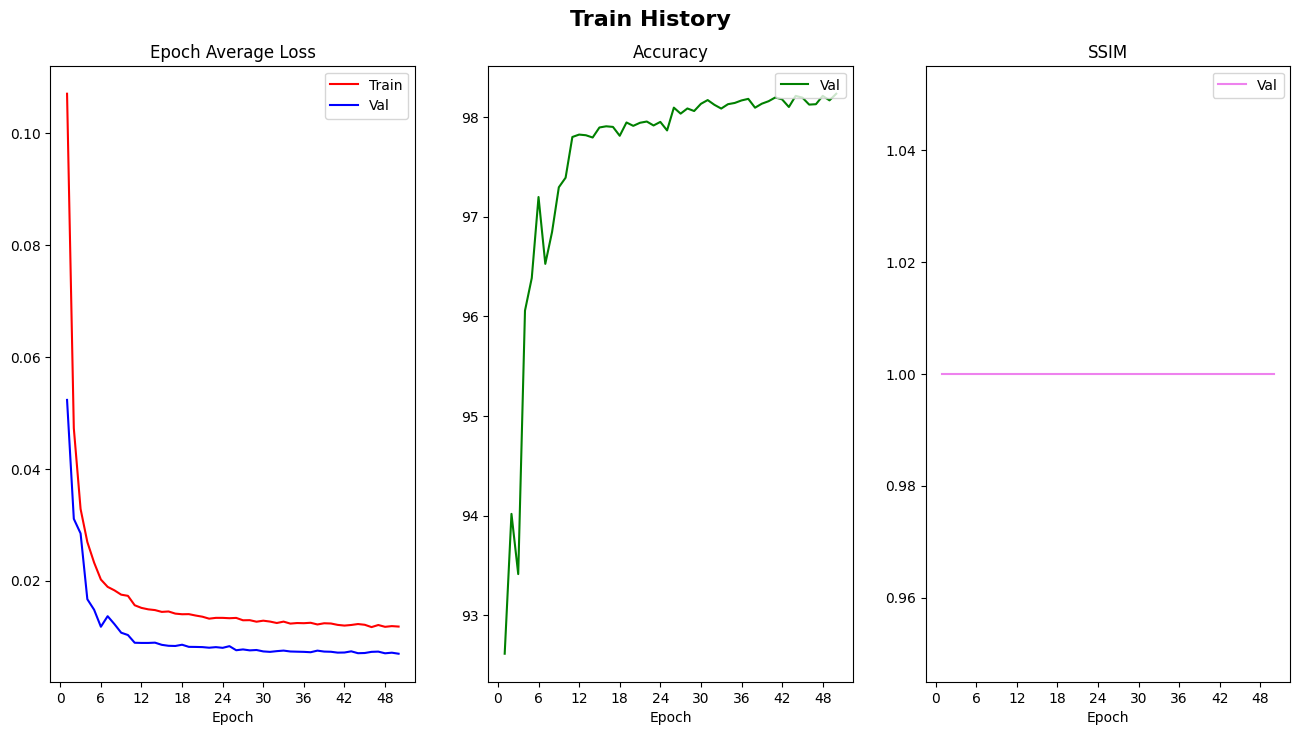

In [ ]:
from matplotlib.ticker import MaxNLocator

trains_epoch = list(range(1, max_epochs + 1, 1))
vals_epochs = epoch_val

plt.figure("train", (16, 8))
plt.suptitle("Train History", x=0.5, y=0.95, fontsize=16, fontweight='bold')
ax = plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(trains_epoch, epoch_train_loss_values, color="red", label="Train")
plt.plot(vals_epochs, epoch_val_loss_values, color="blue", label="Val")
plt.legend(loc="upper right")

ax = plt.subplot(1, 3, 2)
plt.title("Accuracy")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(vals_epochs, accuracy_list, color="green", label="Val")
plt.legend(loc="upper right")

ax = plt.subplot(1, 3, 3)
plt.title("SSIM")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(vals_epochs, ssim_list, color="violet", label="Val")
plt.legend(loc="upper right")

### Prediction on the test set
First, we create the dataloader from the test dataset we defined at the beginning.

In [ ]:
import os
# Create the test dataloader
num_workers = os.cpu_count() - 1

test_dataloader = DataLoader(
    test_ds,
    batch_size=1,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

# Create an iterator to iterate over the test dataloader
test_dataloader_iter = iter(test_dataloader)

Then, we perform the inference on a random sample from the test dataset and plot the prediction.

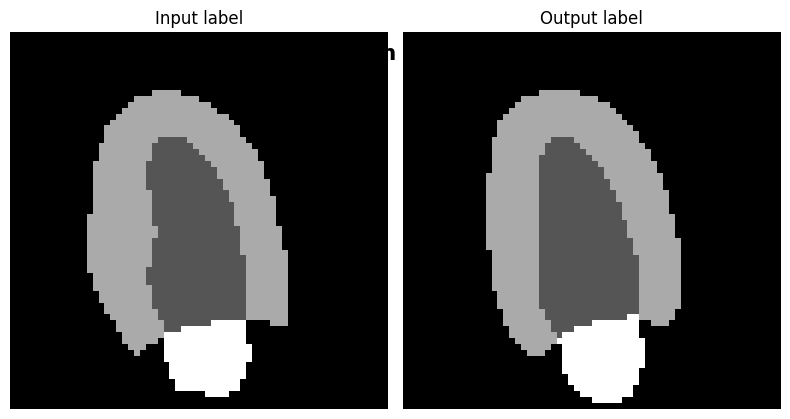

In [ ]:
import torch
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

batch_data = next(test_dataloader_iter)
#model = torch.load('/content/drive/MyDrive/project_ae/logs/ae/best_metric_model.pth', map_location=torch.device('cpu'))
model = torch.load('/content/drive/MyDrive/project_ae/logs/ae/ae_second_step/best_metric_model_16.pth')

with torch.no_grad():
    model.eval()
    model.to(device)
    label = batch_data["label"].to(device)
    output = model(label)

    one_channel_test_outputs = torch.argmax(output, dim=1, keepdim=True)
    one_channel_test_inputs = torch.argmax(label, dim=1, keepdim=True)

    one_channel_test_outputs = one_channel_test_outputs.squeeze().detach().cpu().numpy().transpose(1, 0)
    one_channel_test_inputs = one_channel_test_inputs.squeeze().detach().cpu().numpy().transpose(1, 0)

# Plot the input label, output label
figure = plt.figure(figsize=(8, 8))
figure.suptitle("Random Sample", x=0.5, y=0.7, fontsize=16, fontweight='bold')
ax = figure.add_subplot(1, 2, 1)
imagesc(ax, one_channel_test_inputs, title="Input label", show_colorbar=False)
ax = figure.add_subplot(1, 2, 2)
imagesc(ax, one_channel_test_outputs, title="Output label", show_colorbar=False)
figure.tight_layout()
plt.show()

Finally, we perform the inference on the whole test dataset and plot the result for the best and the worst prediction.

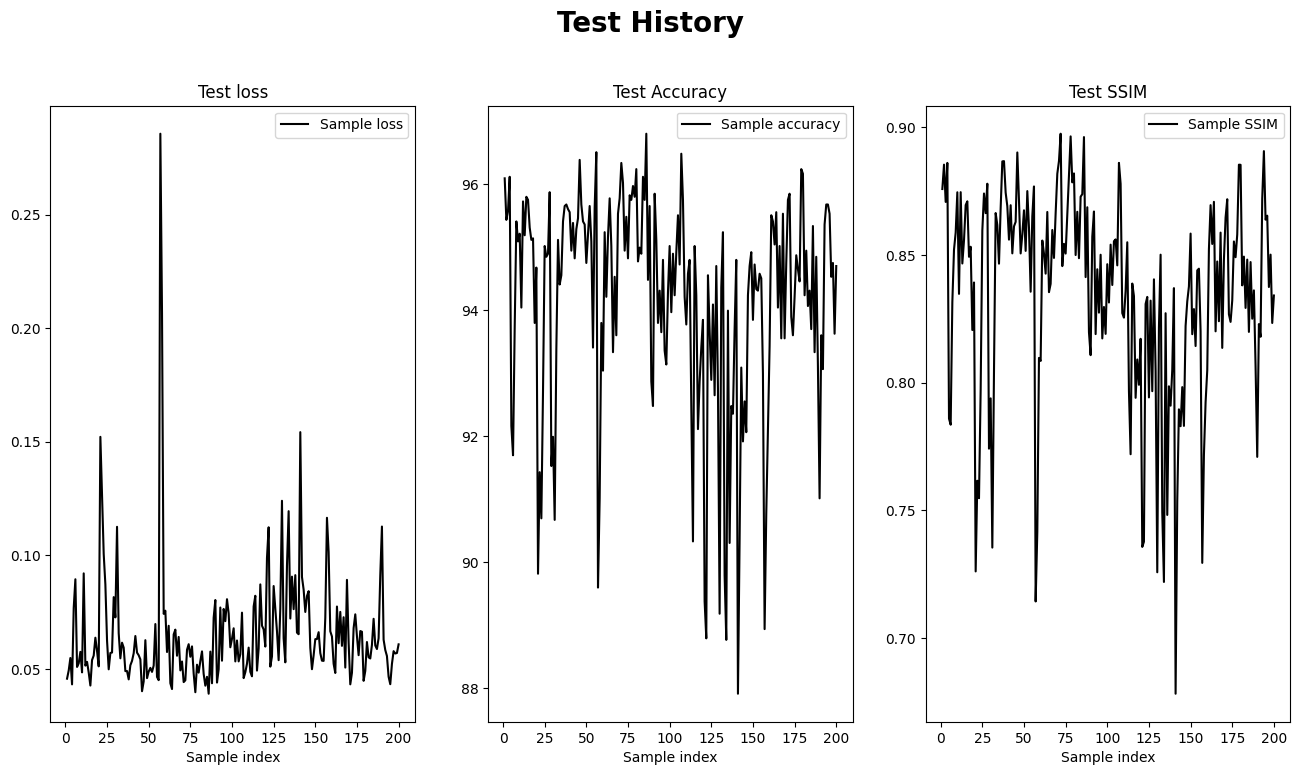

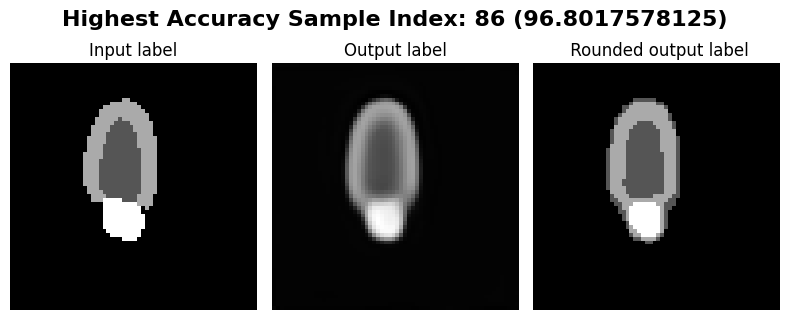

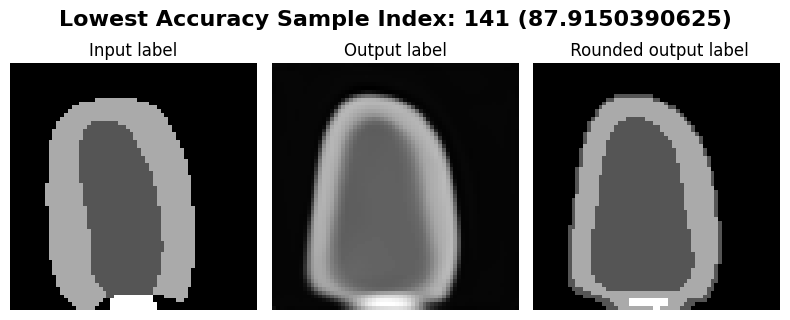

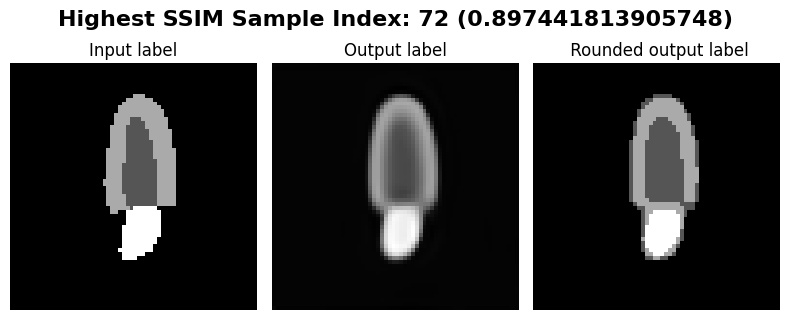

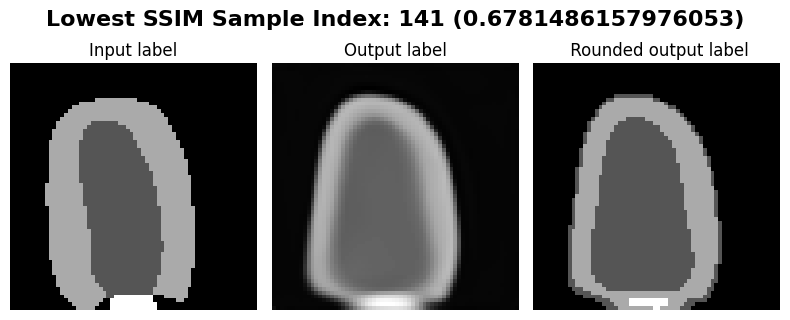

In [ ]:
import torch
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.nn import MSELoss

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#model = torch.load('/content/drive/MyDrive/project_ae/logs/ae/best_metric_model.pth', map_location=torch.device('cpu'))
model = torch.load('/content/drive/MyDrive/project_ae/logs/ae/best_metric_model_16.pth')

test_loss_function = MSELoss()
test_loss_list = []

test_accuracy_list = []
test_ssim_list = []

test_step = 0
max_acc = 0.0
min_acc = 100.0
max_ssim = 0.0
min_ssim = 1.0
max_acc_sample = None
min_acc_sample = None
max_ssim_sample = None
min_ssim_sample = None

with torch.no_grad():
    for test_batch_data in test_dataloader:
        test_step += 1
        model.eval()
        model.to(device)
        test_inputs = test_batch_data["label"].to(device)
        test_outputs = model(test_inputs)
        test_loss = test_loss_function(test_outputs, test_inputs)
        test_loss_list.append(test_loss.item())

        # accuracy calculation for test dataset
        round_test_outputs = torch.round(test_outputs)
        test_correct_pixel = torch.sum(torch.eq(test_inputs, round_test_outputs)).item()
        test_total_pixel = test_inputs.numel()
        test_acc = (test_correct_pixel / test_total_pixel) * 100
        test_accuracy_list.append(test_acc)

        # ssim calculation for test dataset
        test_out_np = test_outputs.cpu().detach().numpy()
        test_in_np = test_inputs.cpu().detach().numpy()
        test_ssim = ssim(test_out_np[0, 0], test_in_np[0, 0])
        test_ssim_list.append(test_ssim)

        # Save the sample with the highest accuracy
        if test_acc > max_acc:
            max_acc = test_acc
            max_acc_sample = {
                'idx': test_step,
                'acc': max_acc,
                'input': test_inputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'output': test_outputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'rounded_output': round_test_outputs.squeeze().transpose(1, 0)
            }

        # Save the sample with the lowest accuracy
        if test_acc < min_acc:
            min_acc = test_acc
            min_acc_sample = {
                'idx': test_step,
                'acc': min_acc,
                'input': test_inputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'output': test_outputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'rounded_output': round_test_outputs.squeeze().transpose(1, 0)
            }

        # Save the sample with the highest SSIM
        if test_ssim > max_ssim:
            max_ssim = test_ssim
            max_ssim_sample = {
                'idx': test_step,
                'ssim': max_ssim,
                'input': test_inputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'output': test_outputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'rounded_output': round_test_outputs.squeeze().transpose(1, 0)
            }

        # Save the sample with the lowest SSIM
        if test_ssim < min_ssim:
            min_ssim = test_ssim
            min_ssim_sample = {
                'idx': test_step,
                'ssim': min_ssim,
                'input': test_inputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'output': test_outputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'rounded_output': round_test_outputs.squeeze().transpose(1, 0)
            }

test_sample_idx = list(range(1, test_step + 1, 1))

plt.figure("Test", (16, 8))
plt.suptitle("Test History", x=0.5, y=1.0, fontsize=20, fontweight='bold')
ax = plt.subplot(1, 3, 1)
plt.title("Test loss")
plt.xlabel("Sample index")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(test_sample_idx, test_loss_list, color="black", label="Sample loss")
plt.legend(loc="upper right")

ax = plt.subplot(1, 3, 2)
plt.title("Test Accuracy")
plt.xlabel("Sample index")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(test_sample_idx, test_accuracy_list, color="black", label="Sample accuracy")
plt.legend(loc="upper right")

ax = plt.subplot(1, 3, 3)
plt.title("Test SSIM")
plt.xlabel("Sample index")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(test_sample_idx, test_ssim_list, color="black", label="Sample SSIM")
plt.legend(loc="upper right")

# Plot the input label, output label, rounded output label
figure = plt.figure(figsize=(8, 8))
figure.suptitle(f"Highest Accuracy Sample Index: {max_acc_sample['idx']} ({max_acc_sample['acc']})", x=0.5, y=0.7, fontsize=16, fontweight='bold')
ax = figure.add_subplot(1, 3, 1)
imagesc(ax, max_acc_sample['input'], title="Input label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 2)
imagesc(ax, max_acc_sample['output'], title="Output label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 3)
imagesc(ax, max_acc_sample['rounded_output'], title=" Rounded output label", show_colorbar=False)
figure.tight_layout()
plt.show()

figure = plt.figure(figsize=(8, 8))
figure.suptitle(f"Lowest Accuracy Sample Index: {min_acc_sample['idx']} ({min_acc_sample['acc']})", x=0.5, y=0.7, fontsize=16, fontweight='bold')
ax = figure.add_subplot(1, 3, 1)
imagesc(ax, min_acc_sample['input'], title="Input label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 2)
imagesc(ax, min_acc_sample['output'], title="Output label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 3)
imagesc(ax, min_acc_sample['rounded_output'], title=" Rounded output label", show_colorbar=False)
figure.tight_layout()
plt.show()

figure = plt.figure(figsize=(8, 8))
figure.suptitle(f"Highest SSIM Sample Index: {max_ssim_sample['idx']} ({max_ssim_sample['ssim']})", x=0.5, y=0.7, fontsize=16, fontweight='bold')
ax = figure.add_subplot(1, 3, 1)
imagesc(ax, max_ssim_sample['input'], title="Input label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 2)
imagesc(ax, max_ssim_sample['output'], title="Output label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 3)
imagesc(ax, max_ssim_sample['rounded_output'], title=" Rounded output label", show_colorbar=False)
figure.tight_layout()
plt.show()

figure = plt.figure(figsize=(8, 8))
figure.suptitle(f"Lowest SSIM Sample Index: {min_ssim_sample['idx']} ({min_ssim_sample['ssim']})", x=0.5, y=0.7, fontsize=16, fontweight='bold')
ax = figure.add_subplot(1, 3, 1)
imagesc(ax, min_ssim_sample['input'], title="Input label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 2)
imagesc(ax, min_ssim_sample['output'], title="Output label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 3)
imagesc(ax, min_ssim_sample['rounded_output'], title=" Rounded output label", show_colorbar=False)
figure.tight_layout()
plt.show()